In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

from V_NAS import Network, get_params_to_update

In [2]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(64, 64, 64),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

In [3]:
data_dir = "./data/"
split_JSON = "dataset_0.json"
datasets = data_dir + split_JSON
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, pin_memory=True
)

Loading dataset: 100%|██████████| 24/24 [02:02<00:00,  5.09s/it]


torch.Size([4, 1, 64, 64, 64]) torch.Size([4, 1, 64, 64, 64])


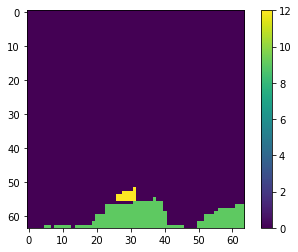

In [4]:
for step, batch in enumerate(train_loader):
    x, y = batch['image'], batch['label']
    print(x.shape, y.shape)
    plt.imshow(y[0, 0, 34])
    plt.colorbar()
    break

In [14]:
model = Network(14).cuda()


model.update_alpha()
a_optimizer = torch.optim.Adam(get_params_to_update(model), lr=0.0003, weight_decay=0.001)

model.update_w()
w_optimizer = torch.optim.AdamW(get_params_to_update(model), lr=1e-4, weight_decay=1e-5)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)



def train_w(model, optimizer, criterion, loader):
    model.train()
    model.update_w()
    for _, batch in enumerate(loader):
        total_loss, step = 0, 0
        x, y = batch["image"].cuda(), batch["label"].cuda()
        optimizer.zero_grad()
        o = model(x)
        loss = criterion(o, y)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()
        step += 1
    return total_loss/step

def train_a(model, optimizer, criterion, loader):
    model.train()
    model.update_alpha()
    for _, batch in enumerate(loader):
        total_loss, step = 0, 0
        x, y = batch["image"].cuda(), batch["label"].cuda()
        optimizer.zero_grad()
        o = model(x)
        loss = criterion(o, y)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()
        step += 1
    return total_loss/step

def final_train(f_epoch):

    for _ in range(f_epoch):
        train_w(model, w_optimizer, loss_function, train_loader)

    for _ in range(3):
        train_w(model, w_optimizer, loss_function, train_loader)
        train_a(model, a_optimizer, loss_function, train_loader)
        model.log()
        print("**********************")


final_train(3)

tensor([-0.0013,  0.0006,  0.0023], device='cuda:0')
tensor([ 0.0022,  0.0007, -0.0018], device='cuda:0')
tensor([ 0.0019, -0.0044, -0.0019], device='cuda:0')
tensor([-0.0007, -0.0009,  0.0025], device='cuda:0')
tensor([ 0.0035, -0.0010, -0.0031], device='cuda:0')
tensor([-1.7996e-03, -4.8647e-05,  1.3903e-03], device='cuda:0')
tensor([-0.0019, -0.0010,  0.0025], device='cuda:0')
tensor([ 0.0008, -0.0009,  0.0002], device='cuda:0')
tensor([-0.0026,  0.0022,  0.0024], device='cuda:0')
tensor([-3.5339e-04, -7.3495e-04, -3.9163e-05], device='cuda:0')
tensor([ 0.0008, -0.0033,  0.0012], device='cuda:0')
tensor([ 0.0037,  0.0012, -0.0032], device='cuda:0')
tensor([-0.0009,  0.0010,  0.0012], device='cuda:0')
tensor([-0.0011, -0.0014,  0.0044], device='cuda:0')
tensor([-0.0012,  0.0001,  0.0013], device='cuda:0')
tensor([-0.0002, -0.0009,  0.0007], device='cuda:0')
tensor([-0.0007,  0.0014, -0.0026], device='cuda:0')
tensor([ 0.0033,  0.0008, -0.0028], device='cuda:0')
tensor([-0.0010,  0.00